In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf

import numpy as np

Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.
['chicken_wings', 'fish_and_chips', 'french_fries', 'hamburger', 'ice_cream', 'onion_rings', 'pizza']
Epoch 1/300
350/350 [==============================] - ETA: 0s - loss: 1.8604 - accuracy: 0.2288
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

Epoch 1: val_loss improved from inf to 1.81652, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
350/350 [==============================] - 20s 44ms/step - loss: 1.8604 - accuracy: 0.2288 - val_loss: 1.8165 - val_accuracy: 0.2500
Epoch 2/300
348/350 [============================>.] - ETA: 0s - loss: 1.8088 - accuracy: 0.2570
Epoch 2: val_accuracy improved from 0.25000 to 0.25847, saving model to /kaggle/working

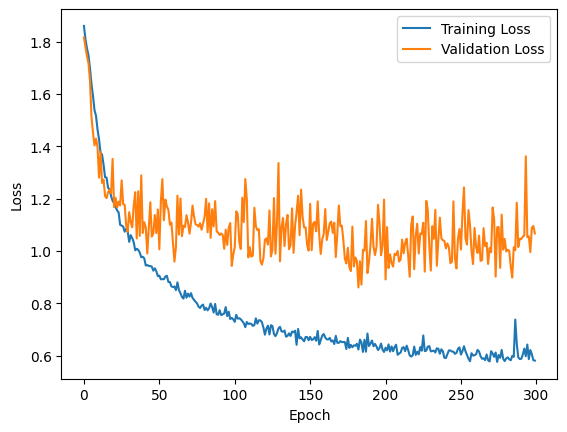

In [31]:
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint

dataPath = "/kaggle/input/fastfood/FastFood"

batchSize = 16
# imgHeight = 128
# imgWidth = 128

imgHeight = 150
imgWidth = 150


trainDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  # color_mode = "grayscale",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  # color_mode = "grayscale",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valBatch = tf.data.experimental.cardinality(valDataset)
testDataset = valDataset.take((2*valBatch) // 3)
valDataset = valDataset.skip((2*valBatch) // 3)

classNames = trainDataset.class_names
print(classNames)

normalization_layer = tf.keras.layers.Rescaling(1./255)
trainDataset = trainDataset.map(lambda x, y: (normalization_layer(x), y))

# Reference to normalise test dataset as well: https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
valDataset = valDataset.map(lambda x, y: (normalization_layer(x), y))
testDataset = testDataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

# trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)

trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=AUTOTUNE)

numClasses = 7
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', seed=20231206),
    tf.keras.layers.RandomRotation(0.2, seed=20231206),
    tf.keras.layers.RandomCrop(128, 128, seed=20231206),
    tf.keras.layers.RandomTranslation(0.2, 0.2, seed=20231206),
    tf.keras.layers.RandomZoom(0.1, seed=20231206),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(numClasses)
])

learningRate = 1e-3

model.compile(
  optimizer=tf.keras.optimizers.Adam(learningRate),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


# Reference to save and load model to continue training: https://stackoverflow.com/questions/45393429/keras-how-to-save-model-and-continue-training

# define the checkpoint
filepath1 = "/kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy"

# To save current model in execution
checkpointCallback = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacksList = [checkpoint]

# define the checkpoint
filepath2 = "/kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss"

# To save current model in execution
checkpointCallbackForLoss = ModelCheckpoint(filepath2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
  trainDataset,
  validation_data=valDataset,
  epochs=300,
  callbacks=[checkpointCallback, checkpointCallbackForLoss]
)

# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Found 7000 files belonging to 7 classes.
# Using 5600 files for training.
# Found 7000 files belonging to 7 classes.
# Using 1400 files for validation.
# ['chicken_wings', 'fish_and_chips', 'french_fries', 'hamburger', 'ice_cream', 'onion_rings', 'pizza']
# Epoch 1/300
# 350/350 [==============================] - ETA: 0s - loss: 1.8604 - accuracy: 0.2288
# Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 1: val_loss improved from inf to 1.81652, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 20s 44ms/step - loss: 1.8604 - accuracy: 0.2288 - val_loss: 1.8165 - val_accuracy: 0.2500
# Epoch 2/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.8088 - accuracy: 0.2570
# Epoch 2: val_accuracy improved from 0.25000 to 0.25847, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 2: val_loss improved from 1.81652 to 1.77928, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 1.8096 - accuracy: 0.2566 - val_loss: 1.7793 - val_accuracy: 0.2585
# Epoch 3/300
# 347/350 [============================>.] - ETA: 0s - loss: 1.7755 - accuracy: 0.2822
# Epoch 3: val_accuracy improved from 0.25847 to 0.29025, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 3: val_loss improved from 1.77928 to 1.74486, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 38ms/step - loss: 1.7751 - accuracy: 0.2827 - val_loss: 1.7449 - val_accuracy: 0.2903
# Epoch 4/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.7483 - accuracy: 0.3030
# Epoch 4: val_accuracy improved from 0.29025 to 0.29873, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 4: val_loss improved from 1.74486 to 1.71775, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 1.7483 - accuracy: 0.3032 - val_loss: 1.7178 - val_accuracy: 0.2987
# Epoch 5/300
# 347/350 [============================>.] - ETA: 0s - loss: 1.6984 - accuracy: 0.3278
# Epoch 5: val_accuracy improved from 0.29873 to 0.35805, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 5: val_loss improved from 1.71775 to 1.65237, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 38ms/step - loss: 1.6988 - accuracy: 0.3275 - val_loss: 1.6524 - val_accuracy: 0.3581
# Epoch 6/300
# 350/350 [==============================] - ETA: 0s - loss: 1.6384 - accuracy: 0.3620
# Epoch 6: val_accuracy improved from 0.35805 to 0.43432, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 6: val_loss improved from 1.65237 to 1.51166, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 1.6384 - accuracy: 0.3620 - val_loss: 1.5117 - val_accuracy: 0.4343
# Epoch 7/300
# 350/350 [==============================] - ETA: 0s - loss: 1.5926 - accuracy: 0.3934
# Epoch 7: val_accuracy did not improve from 0.43432

# Epoch 7: val_loss improved from 1.51166 to 1.45349, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 10s 27ms/step - loss: 1.5926 - accuracy: 0.3934 - val_loss: 1.4535 - val_accuracy: 0.4301
# Epoch 8/300
# 350/350 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.4175
# Epoch 8: val_accuracy improved from 0.43432 to 0.47881, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 8: val_loss improved from 1.45349 to 1.40376, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 1.5385 - accuracy: 0.4175 - val_loss: 1.4038 - val_accuracy: 0.4788
# Epoch 9/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.5169 - accuracy: 0.4239
# Epoch 9: val_accuracy did not improve from 0.47881

# Epoch 9: val_loss did not improve from 1.40376
# 350/350 [==============================] - 6s 17ms/step - loss: 1.5170 - accuracy: 0.4238 - val_loss: 1.4294 - val_accuracy: 0.4555
# Epoch 10/300
# 347/350 [============================>.] - ETA: 0s - loss: 1.4649 - accuracy: 0.4611
# Epoch 10: val_accuracy improved from 0.47881 to 0.48093, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 10: val_loss improved from 1.40376 to 1.39875, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 14s 39ms/step - loss: 1.4648 - accuracy: 0.4620 - val_loss: 1.3987 - val_accuracy: 0.4809
# Epoch 11/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.4276 - accuracy: 0.4626
# Epoch 11: val_accuracy improved from 0.48093 to 0.54237, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 11: val_loss improved from 1.39875 to 1.28047, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 1.4276 - accuracy: 0.4629 - val_loss: 1.2805 - val_accuracy: 0.5424
# Epoch 12/300
# 347/350 [============================>.] - ETA: 0s - loss: 1.3755 - accuracy: 0.4960
# Epoch 12: val_accuracy did not improve from 0.54237

# Epoch 12: val_loss did not improve from 1.28047
# 350/350 [==============================] - 6s 17ms/step - loss: 1.3762 - accuracy: 0.4963 - val_loss: 1.3790 - val_accuracy: 0.5106
# Epoch 13/300
# 350/350 [==============================] - ETA: 0s - loss: 1.3683 - accuracy: 0.5013
# Epoch 13: val_accuracy did not improve from 0.54237

# Epoch 13: val_loss improved from 1.28047 to 1.26027, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 26ms/step - loss: 1.3683 - accuracy: 0.5013 - val_loss: 1.2603 - val_accuracy: 0.5297
# Epoch 14/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.3305 - accuracy: 0.5057
# Epoch 14: val_accuracy improved from 0.54237 to 0.56356, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 14: val_loss did not improve from 1.26027
# 350/350 [==============================] - 9s 27ms/step - loss: 1.3307 - accuracy: 0.5057 - val_loss: 1.2729 - val_accuracy: 0.5636
# Epoch 15/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.2803 - accuracy: 0.5296
# Epoch 15: val_accuracy did not improve from 0.56356

# Epoch 15: val_loss improved from 1.26027 to 1.21042, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 27ms/step - loss: 1.2822 - accuracy: 0.5289 - val_loss: 1.2104 - val_accuracy: 0.5508
# Epoch 16/300
# 350/350 [==============================] - ETA: 0s - loss: 1.2807 - accuracy: 0.5286
# Epoch 16: val_accuracy did not improve from 0.56356

# Epoch 16: val_loss improved from 1.21042 to 1.20235, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 10s 30ms/step - loss: 1.2807 - accuracy: 0.5286 - val_loss: 1.2024 - val_accuracy: 0.5636
# Epoch 17/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.2412 - accuracy: 0.5431
# Epoch 17: val_accuracy did not improve from 0.56356

# Epoch 17: val_loss did not improve from 1.20235
# 350/350 [==============================] - 6s 18ms/step - loss: 1.2414 - accuracy: 0.5430 - val_loss: 1.2246 - val_accuracy: 0.5508
# Epoch 18/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.2352 - accuracy: 0.5393
# Epoch 18: val_accuracy improved from 0.56356 to 0.56568, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 18: val_loss did not improve from 1.20235
# 350/350 [==============================] - 9s 27ms/step - loss: 1.2358 - accuracy: 0.5395 - val_loss: 1.2336 - val_accuracy: 0.5657
# Epoch 19/300
# 347/350 [============================>.] - ETA: 0s - loss: 1.2080 - accuracy: 0.5564
# Epoch 19: val_accuracy did not improve from 0.56568

# Epoch 19: val_loss did not improve from 1.20235
# 350/350 [==============================] - 6s 18ms/step - loss: 1.2097 - accuracy: 0.5559 - val_loss: 1.2212 - val_accuracy: 0.5339
# Epoch 20/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.1907 - accuracy: 0.5652
# Epoch 20: val_accuracy did not improve from 0.56568

# Epoch 20: val_loss did not improve from 1.20235
# 350/350 [==============================] - 6s 17ms/step - loss: 1.1922 - accuracy: 0.5650 - val_loss: 1.3522 - val_accuracy: 0.5106
# Epoch 21/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.1817 - accuracy: 0.5621
# Epoch 21: val_accuracy improved from 0.56568 to 0.57627, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 21: val_loss improved from 1.20235 to 1.16806, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 1.1822 - accuracy: 0.5620 - val_loss: 1.1681 - val_accuracy: 0.5763
# Epoch 22/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.1678 - accuracy: 0.5795
# Epoch 22: val_accuracy improved from 0.57627 to 0.59534, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 22: val_loss did not improve from 1.16806
# 350/350 [==============================] - 9s 27ms/step - loss: 1.1674 - accuracy: 0.5796 - val_loss: 1.2034 - val_accuracy: 0.5953
# Epoch 23/300
# 350/350 [==============================] - ETA: 0s - loss: 1.1553 - accuracy: 0.5845
# Epoch 23: val_accuracy did not improve from 0.59534

# Epoch 23: val_loss improved from 1.16806 to 1.16638, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 27ms/step - loss: 1.1553 - accuracy: 0.5845 - val_loss: 1.1664 - val_accuracy: 0.5953
# Epoch 24/300
# 350/350 [==============================] - ETA: 0s - loss: 1.1476 - accuracy: 0.5814
# Epoch 24: val_accuracy did not improve from 0.59534

# Epoch 24: val_loss did not improve from 1.16638
# 350/350 [==============================] - 6s 18ms/step - loss: 1.1476 - accuracy: 0.5814 - val_loss: 1.1891 - val_accuracy: 0.5742
# Epoch 25/300
# 350/350 [==============================] - ETA: 0s - loss: 1.0999 - accuracy: 0.5948
# Epoch 25: val_accuracy did not improve from 0.59534

# Epoch 25: val_loss did not improve from 1.16638
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0999 - accuracy: 0.5948 - val_loss: 1.1743 - val_accuracy: 0.5678
# Epoch 26/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.0960 - accuracy: 0.5976
# Epoch 26: val_accuracy did not improve from 0.59534

# Epoch 26: val_loss did not improve from 1.16638
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0971 - accuracy: 0.5970 - val_loss: 1.2703 - val_accuracy: 0.5699
# Epoch 27/300
# 347/350 [============================>.] - ETA: 0s - loss: 1.0919 - accuracy: 0.6057
# Epoch 27: val_accuracy improved from 0.59534 to 0.61441, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 27: val_loss did not improve from 1.16638
# 350/350 [==============================] - 9s 26ms/step - loss: 1.0937 - accuracy: 0.6052 - val_loss: 1.1793 - val_accuracy: 0.6144
# Epoch 28/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.0732 - accuracy: 0.6155
# Epoch 28: val_accuracy did not improve from 0.61441

# Epoch 28: val_loss did not improve from 1.16638
# 350/350 [==============================] - 6s 18ms/step - loss: 1.0740 - accuracy: 0.6154 - val_loss: 1.1773 - val_accuracy: 0.5869
# Epoch 29/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.0841 - accuracy: 0.6098
# Epoch 29: val_accuracy improved from 0.61441 to 0.64619, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 29: val_loss improved from 1.16638 to 1.09780, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 14s 40ms/step - loss: 1.0851 - accuracy: 0.6093 - val_loss: 1.0978 - val_accuracy: 0.6462
# Epoch 30/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.0733 - accuracy: 0.6044
# Epoch 30: val_accuracy did not improve from 0.64619

# Epoch 30: val_loss improved from 1.09780 to 1.07393, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 10s 27ms/step - loss: 1.0746 - accuracy: 0.6043 - val_loss: 1.0739 - val_accuracy: 0.6186
# Epoch 31/300
# 349/350 [============================>.] - ETA: 0s - loss: 1.0352 - accuracy: 0.6316
# Epoch 31: val_accuracy did not improve from 0.64619

# Epoch 31: val_loss did not improve from 1.07393
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0350 - accuracy: 0.6316 - val_loss: 1.1484 - val_accuracy: 0.6144
# Epoch 32/300
# 348/350 [============================>.] - ETA: 0s - loss: 1.0581 - accuracy: 0.6185
# Epoch 32: val_accuracy did not improve from 0.64619

# Epoch 32: val_loss did not improve from 1.07393
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0607 - accuracy: 0.6179 - val_loss: 1.1104 - val_accuracy: 0.6165
# Epoch 33/300
# 350/350 [==============================] - ETA: 0s - loss: 1.0496 - accuracy: 0.6205
# Epoch 33: val_accuracy did not improve from 0.64619

# Epoch 33: val_loss did not improve from 1.07393
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0496 - accuracy: 0.6205 - val_loss: 1.0907 - val_accuracy: 0.6441
# Epoch 34/300
# 350/350 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.6277
# Epoch 34: val_accuracy did not improve from 0.64619

# Epoch 34: val_loss did not improve from 1.07393
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0335 - accuracy: 0.6277 - val_loss: 1.1737 - val_accuracy: 0.6102
# Epoch 35/300
# 350/350 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.6320
# Epoch 35: val_accuracy did not improve from 0.64619

# Epoch 35: val_loss did not improve from 1.07393
# 350/350 [==============================] - 6s 17ms/step - loss: 1.0028 - accuracy: 0.6320 - val_loss: 1.2247 - val_accuracy: 0.5869
# Epoch 36/300
# 350/350 [==============================] - ETA: 0s - loss: 1.0086 - accuracy: 0.6371
# Epoch 36: val_accuracy did not improve from 0.64619

# Epoch 36: val_loss improved from 1.07393 to 1.04797, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 27ms/step - loss: 1.0086 - accuracy: 0.6371 - val_loss: 1.0480 - val_accuracy: 0.6356
# Epoch 37/300
# 350/350 [==============================] - ETA: 0s - loss: 1.0047 - accuracy: 0.6418
# Epoch 37: val_accuracy did not improve from 0.64619

# Epoch 37: val_loss did not improve from 1.04797
# 350/350 [==============================] - 6s 18ms/step - loss: 1.0047 - accuracy: 0.6418 - val_loss: 1.2284 - val_accuracy: 0.5636
# Epoch 38/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.9945 - accuracy: 0.6426
# Epoch 38: val_accuracy did not improve from 0.64619

# Epoch 38: val_loss did not improve from 1.04797
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9943 - accuracy: 0.6429 - val_loss: 1.0577 - val_accuracy: 0.6441
# Epoch 39/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.9754 - accuracy: 0.6557
# Epoch 39: val_accuracy did not improve from 0.64619

# Epoch 39: val_loss did not improve from 1.04797
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9760 - accuracy: 0.6552 - val_loss: 1.2892 - val_accuracy: 0.5869
# Epoch 40/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.9766 - accuracy: 0.6507
# Epoch 40: val_accuracy improved from 0.64619 to 0.64831, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 40: val_loss did not improve from 1.04797
# 350/350 [==============================] - 9s 27ms/step - loss: 0.9782 - accuracy: 0.6511 - val_loss: 1.0689 - val_accuracy: 0.6483
# Epoch 41/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.9728 - accuracy: 0.6494
# Epoch 41: val_accuracy did not improve from 0.64831

# Epoch 41: val_loss did not improve from 1.04797
# 350/350 [==============================] - 6s 18ms/step - loss: 0.9722 - accuracy: 0.6496 - val_loss: 1.1100 - val_accuracy: 0.6314
# Epoch 42/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.9435 - accuracy: 0.6597
# Epoch 42: val_accuracy did not improve from 0.64831

# Epoch 42: val_loss did not improve from 1.04797
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9444 - accuracy: 0.6596 - val_loss: 1.0900 - val_accuracy: 0.6462
# Epoch 43/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.9467 - accuracy: 0.6622
# Epoch 43: val_accuracy improved from 0.64831 to 0.66525, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 43: val_loss improved from 1.04797 to 0.99045, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 13s 36ms/step - loss: 0.9465 - accuracy: 0.6618 - val_loss: 0.9905 - val_accuracy: 0.6653
# Epoch 44/300
# 350/350 [==============================] - ETA: 0s - loss: 0.9428 - accuracy: 0.6564
# Epoch 44: val_accuracy did not improve from 0.66525

# Epoch 44: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9428 - accuracy: 0.6564 - val_loss: 1.0859 - val_accuracy: 0.6483
# Epoch 45/300
# 350/350 [==============================] - ETA: 0s - loss: 0.9428 - accuracy: 0.6611
# Epoch 45: val_accuracy did not improve from 0.66525

# Epoch 45: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9428 - accuracy: 0.6611 - val_loss: 1.1864 - val_accuracy: 0.6165
# Epoch 46/300
# 350/350 [==============================] - ETA: 0s - loss: 0.9403 - accuracy: 0.6641
# Epoch 46: val_accuracy did not improve from 0.66525

# Epoch 46: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9403 - accuracy: 0.6641 - val_loss: 1.0550 - val_accuracy: 0.6398
# Epoch 47/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.9248 - accuracy: 0.6677
# Epoch 47: val_accuracy did not improve from 0.66525

# Epoch 47: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9249 - accuracy: 0.6680 - val_loss: 1.0675 - val_accuracy: 0.6589
# Epoch 48/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.9341 - accuracy: 0.6610
# Epoch 48: val_accuracy did not improve from 0.66525

# Epoch 48: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9341 - accuracy: 0.6612 - val_loss: 1.1377 - val_accuracy: 0.6525
# Epoch 49/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.9229 - accuracy: 0.6720
# Epoch 49: val_accuracy did not improve from 0.66525

# Epoch 49: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9227 - accuracy: 0.6723 - val_loss: 1.0687 - val_accuracy: 0.6547
# Epoch 50/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.9023 - accuracy: 0.6839
# Epoch 50: val_accuracy did not improve from 0.66525

# Epoch 50: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9038 - accuracy: 0.6836 - val_loss: 1.1593 - val_accuracy: 0.6398
# Epoch 51/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.9055 - accuracy: 0.6747
# Epoch 51: val_accuracy improved from 0.66525 to 0.68008, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 51: val_loss did not improve from 0.99045
# 350/350 [==============================] - 9s 27ms/step - loss: 0.9061 - accuracy: 0.6752 - val_loss: 1.0065 - val_accuracy: 0.6801
# Epoch 52/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6818
# Epoch 52: val_accuracy did not improve from 0.68008

# Epoch 52: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8919 - accuracy: 0.6818 - val_loss: 1.1897 - val_accuracy: 0.6462
# Epoch 53/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.8932 - accuracy: 0.6798
# Epoch 53: val_accuracy did not improve from 0.68008

# Epoch 53: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8928 - accuracy: 0.6802 - val_loss: 1.2750 - val_accuracy: 0.6165
# Epoch 54/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.6855
# Epoch 54: val_accuracy did not improve from 0.68008

# Epoch 54: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8920 - accuracy: 0.6855 - val_loss: 1.1178 - val_accuracy: 0.6208
# Epoch 55/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.9029 - accuracy: 0.6812
# Epoch 55: val_accuracy did not improve from 0.68008

# Epoch 55: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9026 - accuracy: 0.6814 - val_loss: 1.1965 - val_accuracy: 0.6123
# Epoch 56/300
# 350/350 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.6777
# Epoch 56: val_accuracy did not improve from 0.68008

# Epoch 56: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.9055 - accuracy: 0.6777 - val_loss: 1.1704 - val_accuracy: 0.6292
# Epoch 57/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.6889
# Epoch 57: val_accuracy did not improve from 0.68008

# Epoch 57: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8819 - accuracy: 0.6889 - val_loss: 1.1577 - val_accuracy: 0.6441
# Epoch 58/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.8788 - accuracy: 0.6941
# Epoch 58: val_accuracy did not improve from 0.68008

# Epoch 58: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8816 - accuracy: 0.6936 - val_loss: 1.1005 - val_accuracy: 0.6462
# Epoch 59/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.8643 - accuracy: 0.6943
# Epoch 59: val_accuracy did not improve from 0.68008

# Epoch 59: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8648 - accuracy: 0.6941 - val_loss: 1.1089 - val_accuracy: 0.6462
# Epoch 60/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8623 - accuracy: 0.6927
# Epoch 60: val_accuracy did not improve from 0.68008

# Epoch 60: val_loss did not improve from 0.99045
# 350/350 [==============================] - 6s 18ms/step - loss: 0.8623 - accuracy: 0.6927 - val_loss: 1.0331 - val_accuracy: 0.6737
# Epoch 61/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8643 - accuracy: 0.6957
# Epoch 61: val_accuracy did not improve from 0.68008

# Epoch 61: val_loss improved from 0.99045 to 0.95968, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 10s 27ms/step - loss: 0.8643 - accuracy: 0.6957 - val_loss: 0.9597 - val_accuracy: 0.6631
# Epoch 62/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.8489 - accuracy: 0.7004
# Epoch 62: val_accuracy did not improve from 0.68008

# Epoch 62: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 18ms/step - loss: 0.8504 - accuracy: 0.7000 - val_loss: 1.0152 - val_accuracy: 0.6610
# Epoch 63/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.8787 - accuracy: 0.6862
# Epoch 63: val_accuracy did not improve from 0.68008

# Epoch 63: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8804 - accuracy: 0.6855 - val_loss: 1.2117 - val_accuracy: 0.6165
# Epoch 64/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8506 - accuracy: 0.7030
# Epoch 64: val_accuracy did not improve from 0.68008

# Epoch 64: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8506 - accuracy: 0.7030 - val_loss: 1.0627 - val_accuracy: 0.6398
# Epoch 65/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.8385 - accuracy: 0.7058
# Epoch 65: val_accuracy did not improve from 0.68008

# Epoch 65: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8386 - accuracy: 0.7057 - val_loss: 1.2009 - val_accuracy: 0.6504
# Epoch 66/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.8245 - accuracy: 0.7097
# Epoch 66: val_accuracy did not improve from 0.68008

# Epoch 66: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8245 - accuracy: 0.7098 - val_loss: 1.0569 - val_accuracy: 0.6674
# Epoch 67/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8182 - accuracy: 0.7061
# Epoch 67: val_accuracy did not improve from 0.68008

# Epoch 67: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8182 - accuracy: 0.7061 - val_loss: 1.0966 - val_accuracy: 0.6377
# Epoch 68/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.8467 - accuracy: 0.7073
# Epoch 68: val_accuracy did not improve from 0.68008

# Epoch 68: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8483 - accuracy: 0.7073 - val_loss: 1.0921 - val_accuracy: 0.6547
# Epoch 69/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.7120
# Epoch 69: val_accuracy did not improve from 0.68008

# Epoch 69: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8216 - accuracy: 0.7120 - val_loss: 1.1369 - val_accuracy: 0.6589
# Epoch 70/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.8367 - accuracy: 0.7156
# Epoch 70: val_accuracy did not improve from 0.68008

# Epoch 70: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8373 - accuracy: 0.7154 - val_loss: 1.1094 - val_accuracy: 0.6589
# Epoch 71/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8258 - accuracy: 0.7113
# Epoch 71: val_accuracy did not improve from 0.68008

# Epoch 71: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8258 - accuracy: 0.7113 - val_loss: 1.0663 - val_accuracy: 0.6716
# Epoch 72/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.8396 - accuracy: 0.7071
# Epoch 72: val_accuracy did not improve from 0.68008

# Epoch 72: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8390 - accuracy: 0.7073 - val_loss: 1.1085 - val_accuracy: 0.6653
# Epoch 73/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.7152
# Epoch 73: val_accuracy did not improve from 0.68008

# Epoch 73: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8210 - accuracy: 0.7152 - val_loss: 1.1739 - val_accuracy: 0.6483
# Epoch 74/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.8138 - accuracy: 0.7219
# Epoch 74: val_accuracy did not improve from 0.68008

# Epoch 74: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8132 - accuracy: 0.7223 - val_loss: 1.1316 - val_accuracy: 0.6419
# Epoch 75/300
# 350/350 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.7173
# Epoch 75: val_accuracy did not improve from 0.68008

# Epoch 75: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8062 - accuracy: 0.7173 - val_loss: 1.1018 - val_accuracy: 0.6695
# Epoch 76/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7990 - accuracy: 0.7204
# Epoch 76: val_accuracy did not improve from 0.68008

# Epoch 76: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.8000 - accuracy: 0.7200 - val_loss: 1.0997 - val_accuracy: 0.6483
# Epoch 77/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7869 - accuracy: 0.7232
# Epoch 77: val_accuracy did not improve from 0.68008

# Epoch 77: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7876 - accuracy: 0.7229 - val_loss: 1.0930 - val_accuracy: 0.6737
# Epoch 78/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.7292
# Epoch 78: val_accuracy did not improve from 0.68008

# Epoch 78: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7822 - accuracy: 0.7291 - val_loss: 1.1064 - val_accuracy: 0.6610
# Epoch 79/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7911 - accuracy: 0.7284
# Epoch 79: val_accuracy did not improve from 0.68008

# Epoch 79: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7911 - accuracy: 0.7286 - val_loss: 1.0813 - val_accuracy: 0.6483
# Epoch 80/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7959 - accuracy: 0.7251
# Epoch 80: val_accuracy did not improve from 0.68008

# Epoch 80: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7953 - accuracy: 0.7254 - val_loss: 1.1044 - val_accuracy: 0.6568
# Epoch 81/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.7282
# Epoch 81: val_accuracy did not improve from 0.68008

# Epoch 81: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7747 - accuracy: 0.7284 - val_loss: 1.1315 - val_accuracy: 0.6780
# Epoch 82/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.7271
# Epoch 82: val_accuracy did not improve from 0.68008

# Epoch 82: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7830 - accuracy: 0.7273 - val_loss: 1.1996 - val_accuracy: 0.6314
# Epoch 83/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7735 - accuracy: 0.7265
# Epoch 83: val_accuracy did not improve from 0.68008

# Epoch 83: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7734 - accuracy: 0.7266 - val_loss: 1.0717 - val_accuracy: 0.6737
# Epoch 84/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7827 - accuracy: 0.7362
# Epoch 84: val_accuracy did not improve from 0.68008

# Epoch 84: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7814 - accuracy: 0.7366 - val_loss: 1.1824 - val_accuracy: 0.6398
# Epoch 85/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.7209
# Epoch 85: val_accuracy did not improve from 0.68008

# Epoch 85: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7994 - accuracy: 0.7209 - val_loss: 1.0504 - val_accuracy: 0.6758
# Epoch 86/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.7125
# Epoch 86: val_accuracy did not improve from 0.68008

# Epoch 86: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7858 - accuracy: 0.7125 - val_loss: 1.1596 - val_accuracy: 0.6419
# Epoch 87/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.7363
# Epoch 87: val_accuracy did not improve from 0.68008

# Epoch 87: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7649 - accuracy: 0.7359 - val_loss: 1.0941 - val_accuracy: 0.6674
# Epoch 88/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7970 - accuracy: 0.7210
# Epoch 88: val_accuracy did not improve from 0.68008

# Epoch 88: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7978 - accuracy: 0.7209 - val_loss: 1.1909 - val_accuracy: 0.6631
# Epoch 89/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7590 - accuracy: 0.7360
# Epoch 89: val_accuracy did not improve from 0.68008

# Epoch 89: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7583 - accuracy: 0.7364 - val_loss: 1.0749 - val_accuracy: 0.6653
# Epoch 90/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.7375
# Epoch 90: val_accuracy did not improve from 0.68008

# Epoch 90: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7563 - accuracy: 0.7375 - val_loss: 1.0706 - val_accuracy: 0.6716
# Epoch 91/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7748 - accuracy: 0.7267
# Epoch 91: val_accuracy did not improve from 0.68008

# Epoch 91: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 18ms/step - loss: 0.7739 - accuracy: 0.7270 - val_loss: 1.0611 - val_accuracy: 0.6568
# Epoch 92/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7540 - accuracy: 0.7362
# Epoch 92: val_accuracy did not improve from 0.68008

# Epoch 92: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7549 - accuracy: 0.7359 - val_loss: 1.0671 - val_accuracy: 0.6695
# Epoch 93/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7579 - accuracy: 0.7380
# Epoch 93: val_accuracy did not improve from 0.68008

# Epoch 93: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7579 - accuracy: 0.7380 - val_loss: 1.0624 - val_accuracy: 0.6483
# Epoch 94/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7619 - accuracy: 0.7399
# Epoch 94: val_accuracy did not improve from 0.68008

# Epoch 94: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7613 - accuracy: 0.7404 - val_loss: 1.0087 - val_accuracy: 0.6674
# Epoch 95/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7861 - accuracy: 0.7321
# Epoch 95: val_accuracy did not improve from 0.68008

# Epoch 95: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7857 - accuracy: 0.7323 - val_loss: 1.0817 - val_accuracy: 0.6271
# Epoch 96/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7523 - accuracy: 0.7387
# Epoch 96: val_accuracy did not improve from 0.68008

# Epoch 96: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7513 - accuracy: 0.7391 - val_loss: 1.0229 - val_accuracy: 0.6674
# Epoch 97/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7695 - accuracy: 0.7288
# Epoch 97: val_accuracy did not improve from 0.68008

# Epoch 97: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7680 - accuracy: 0.7295 - val_loss: 1.0889 - val_accuracy: 0.6758
# Epoch 98/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7408 - accuracy: 0.7432
# Epoch 98: val_accuracy did not improve from 0.68008

# Epoch 98: val_loss did not improve from 0.95968
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7403 - accuracy: 0.7432 - val_loss: 1.1071 - val_accuracy: 0.6589
# Epoch 99/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.7400
# Epoch 99: val_accuracy improved from 0.68008 to 0.70551, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 99: val_loss improved from 0.95968 to 0.94320, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 14s 40ms/step - loss: 0.7443 - accuracy: 0.7400 - val_loss: 0.9432 - val_accuracy: 0.7055
# Epoch 100/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.7477
# Epoch 100: val_accuracy did not improve from 0.70551

# Epoch 100: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.7390 - accuracy: 0.7479 - val_loss: 0.9856 - val_accuracy: 0.6907
# Epoch 101/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7287 - accuracy: 0.7453
# Epoch 101: val_accuracy did not improve from 0.70551

# Epoch 101: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7293 - accuracy: 0.7454 - val_loss: 1.0146 - val_accuracy: 0.6949
# Epoch 102/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7554 - accuracy: 0.7446
# Epoch 102: val_accuracy did not improve from 0.70551

# Epoch 102: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7562 - accuracy: 0.7446 - val_loss: 1.1519 - val_accuracy: 0.6504
# Epoch 103/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7398 - accuracy: 0.7414
# Epoch 103: val_accuracy did not improve from 0.70551

# Epoch 103: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7416 - accuracy: 0.7420 - val_loss: 1.1408 - val_accuracy: 0.6695
# Epoch 104/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7430 - accuracy: 0.7401
# Epoch 104: val_accuracy did not improve from 0.70551

# Epoch 104: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7431 - accuracy: 0.7404 - val_loss: 1.0341 - val_accuracy: 0.6610
# Epoch 105/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7396 - accuracy: 0.7409
# Epoch 105: val_accuracy did not improve from 0.70551

# Epoch 105: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.7395 - accuracy: 0.7407 - val_loss: 1.0080 - val_accuracy: 0.6568
# Epoch 106/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7329 - accuracy: 0.7473
# Epoch 106: val_accuracy did not improve from 0.70551

# Epoch 106: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7320 - accuracy: 0.7482 - val_loss: 1.2038 - val_accuracy: 0.6250
# Epoch 107/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7238 - accuracy: 0.7496
# Epoch 107: val_accuracy did not improve from 0.70551

# Epoch 107: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7243 - accuracy: 0.7496 - val_loss: 1.1110 - val_accuracy: 0.6653
# Epoch 108/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.7548
# Epoch 108: val_accuracy did not improve from 0.70551

# Epoch 108: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7089 - accuracy: 0.7548 - val_loss: 1.2752 - val_accuracy: 0.6483
# Epoch 109/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7286 - accuracy: 0.7421
# Epoch 109: val_accuracy did not improve from 0.70551

# Epoch 109: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.7287 - accuracy: 0.7423 - val_loss: 1.1988 - val_accuracy: 0.6589
# Epoch 110/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.7486
# Epoch 110: val_accuracy did not improve from 0.70551

# Epoch 110: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.7212 - accuracy: 0.7486 - val_loss: 0.9759 - val_accuracy: 0.6907
# Epoch 111/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7227 - accuracy: 0.7484
# Epoch 111: val_accuracy did not improve from 0.70551

# Epoch 111: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7231 - accuracy: 0.7482 - val_loss: 1.0146 - val_accuracy: 0.6674
# Epoch 112/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7198 - accuracy: 0.7471
# Epoch 112: val_accuracy improved from 0.70551 to 0.71398, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 112: val_loss did not improve from 0.94320
# 350/350 [==============================] - 9s 27ms/step - loss: 0.7216 - accuracy: 0.7468 - val_loss: 0.9784 - val_accuracy: 0.7140
# Epoch 113/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7121 - accuracy: 0.7543
# Epoch 113: val_accuracy did not improve from 0.71398

# Epoch 113: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7139 - accuracy: 0.7539 - val_loss: 0.9830 - val_accuracy: 0.6970
# Epoch 114/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7473
# Epoch 114: val_accuracy did not improve from 0.71398

# Epoch 114: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7169 - accuracy: 0.7473 - val_loss: 1.1655 - val_accuracy: 0.6695
# Epoch 115/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7440 - accuracy: 0.7407
# Epoch 115: val_accuracy did not improve from 0.71398

# Epoch 115: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7427 - accuracy: 0.7414 - val_loss: 1.0944 - val_accuracy: 0.6864
# Epoch 116/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7223 - accuracy: 0.7505
# Epoch 116: val_accuracy did not improve from 0.71398

# Epoch 116: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7225 - accuracy: 0.7507 - val_loss: 1.0795 - val_accuracy: 0.6992
# Epoch 117/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.7518
# Epoch 117: val_accuracy did not improve from 0.71398

# Epoch 117: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7354 - accuracy: 0.7518 - val_loss: 1.0831 - val_accuracy: 0.6758
# Epoch 118/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7352 - accuracy: 0.7434
# Epoch 118: val_accuracy did not improve from 0.71398

# Epoch 118: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7347 - accuracy: 0.7434 - val_loss: 0.9623 - val_accuracy: 0.6801
# Epoch 119/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7294 - accuracy: 0.7468
# Epoch 119: val_accuracy did not improve from 0.71398

# Epoch 119: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7281 - accuracy: 0.7475 - val_loss: 0.9480 - val_accuracy: 0.6907
# Epoch 120/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.7053 - accuracy: 0.7522
# Epoch 120: val_accuracy did not improve from 0.71398

# Epoch 120: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7075 - accuracy: 0.7514 - val_loss: 0.9724 - val_accuracy: 0.6970
# Epoch 121/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6803 - accuracy: 0.7655
# Epoch 121: val_accuracy did not improve from 0.71398

# Epoch 121: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6802 - accuracy: 0.7657 - val_loss: 1.0431 - val_accuracy: 0.6801
# Epoch 122/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7046 - accuracy: 0.7583
# Epoch 122: val_accuracy did not improve from 0.71398

# Epoch 122: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7038 - accuracy: 0.7580 - val_loss: 1.0483 - val_accuracy: 0.6801
# Epoch 123/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7151 - accuracy: 0.7552
# Epoch 123: val_accuracy did not improve from 0.71398

# Epoch 123: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7149 - accuracy: 0.7552 - val_loss: 1.0248 - val_accuracy: 0.7034
# Epoch 124/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.7651
# Epoch 124: val_accuracy did not improve from 0.71398

# Epoch 124: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6812 - accuracy: 0.7646 - val_loss: 1.1549 - val_accuracy: 0.6864
# Epoch 125/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7169 - accuracy: 0.7434
# Epoch 125: val_accuracy did not improve from 0.71398

# Epoch 125: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7164 - accuracy: 0.7437 - val_loss: 0.9794 - val_accuracy: 0.7013
# Epoch 126/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7132 - accuracy: 0.7530
# Epoch 126: val_accuracy did not improve from 0.71398

# Epoch 126: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7133 - accuracy: 0.7529 - val_loss: 1.0046 - val_accuracy: 0.6992
# Epoch 127/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.7609
# Epoch 127: val_accuracy did not improve from 0.71398

# Epoch 127: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6827 - accuracy: 0.7613 - val_loss: 1.2024 - val_accuracy: 0.6589
# Epoch 128/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.7698
# Epoch 128: val_accuracy did not improve from 0.71398

# Epoch 128: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6747 - accuracy: 0.7696 - val_loss: 0.9895 - val_accuracy: 0.6716
# Epoch 129/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.7596
# Epoch 129: val_accuracy did not improve from 0.71398

# Epoch 129: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6862 - accuracy: 0.7596 - val_loss: 1.1043 - val_accuracy: 0.6737
# Epoch 130/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7058 - accuracy: 0.7572
# Epoch 130: val_accuracy did not improve from 0.71398

# Epoch 130: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7044 - accuracy: 0.7575 - val_loss: 1.3367 - val_accuracy: 0.6377
# Epoch 131/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.7097 - accuracy: 0.7559
# Epoch 131: val_accuracy did not improve from 0.71398

# Epoch 131: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7103 - accuracy: 0.7557 - val_loss: 0.9608 - val_accuracy: 0.6758
# Epoch 132/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.7609
# Epoch 132: val_accuracy did not improve from 0.71398

# Epoch 132: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6931 - accuracy: 0.7609 - val_loss: 1.0908 - val_accuracy: 0.6589
# Epoch 133/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7534
# Epoch 133: val_accuracy did not improve from 0.71398

# Epoch 133: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6915 - accuracy: 0.7530 - val_loss: 1.1262 - val_accuracy: 0.6589
# Epoch 134/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.7652
# Epoch 134: val_accuracy did not improve from 0.71398

# Epoch 134: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6960 - accuracy: 0.7654 - val_loss: 1.0189 - val_accuracy: 0.6864
# Epoch 135/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.7726
# Epoch 135: val_accuracy did not improve from 0.71398

# Epoch 135: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6727 - accuracy: 0.7723 - val_loss: 1.1028 - val_accuracy: 0.6780
# Epoch 136/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.7673
# Epoch 136: val_accuracy did not improve from 0.71398

# Epoch 136: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6755 - accuracy: 0.7673 - val_loss: 1.1378 - val_accuracy: 0.6780
# Epoch 137/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.7651
# Epoch 137: val_accuracy did not improve from 0.71398

# Epoch 137: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6855 - accuracy: 0.7655 - val_loss: 1.0070 - val_accuracy: 0.6674
# Epoch 138/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.7633
# Epoch 138: val_accuracy did not improve from 0.71398

# Epoch 138: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6755 - accuracy: 0.7636 - val_loss: 1.0228 - val_accuracy: 0.6886
# Epoch 139/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6911 - accuracy: 0.7649
# Epoch 139: val_accuracy did not improve from 0.71398

# Epoch 139: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6921 - accuracy: 0.7643 - val_loss: 1.1631 - val_accuracy: 0.6949
# Epoch 140/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6902 - accuracy: 0.7636
# Epoch 140: val_accuracy did not improve from 0.71398

# Epoch 140: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6898 - accuracy: 0.7636 - val_loss: 0.9935 - val_accuracy: 0.7097
# Epoch 141/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6959 - accuracy: 0.7572
# Epoch 141: val_accuracy did not improve from 0.71398

# Epoch 141: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6956 - accuracy: 0.7573 - val_loss: 1.0967 - val_accuracy: 0.6695
# Epoch 142/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6405 - accuracy: 0.7814
# Epoch 142: val_accuracy did not improve from 0.71398

# Epoch 142: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6416 - accuracy: 0.7811 - val_loss: 1.1481 - val_accuracy: 0.6907
# Epoch 143/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.7031 - accuracy: 0.7588
# Epoch 143: val_accuracy did not improve from 0.71398

# Epoch 143: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.7021 - accuracy: 0.7593 - val_loss: 1.2114 - val_accuracy: 0.6695
# Epoch 144/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7736
# Epoch 144: val_accuracy did not improve from 0.71398

# Epoch 144: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6661 - accuracy: 0.7736 - val_loss: 1.0606 - val_accuracy: 0.6907
# Epoch 145/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.7710
# Epoch 145: val_accuracy did not improve from 0.71398

# Epoch 145: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6701 - accuracy: 0.7711 - val_loss: 1.2348 - val_accuracy: 0.6356
# Epoch 146/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7638
# Epoch 146: val_accuracy did not improve from 0.71398

# Epoch 146: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6617 - accuracy: 0.7638 - val_loss: 1.1305 - val_accuracy: 0.6525
# Epoch 147/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6553 - accuracy: 0.7725
# Epoch 147: val_accuracy did not improve from 0.71398

# Epoch 147: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6549 - accuracy: 0.7725 - val_loss: 1.0900 - val_accuracy: 0.6568
# Epoch 148/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.7649
# Epoch 148: val_accuracy did not improve from 0.71398

# Epoch 148: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6716 - accuracy: 0.7652 - val_loss: 1.0904 - val_accuracy: 0.6716
# Epoch 149/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.7654
# Epoch 149: val_accuracy did not improve from 0.71398

# Epoch 149: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6711 - accuracy: 0.7652 - val_loss: 1.0228 - val_accuracy: 0.6864
# Epoch 150/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7711
# Epoch 150: val_accuracy did not improve from 0.71398

# Epoch 150: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6590 - accuracy: 0.7711 - val_loss: 1.0019 - val_accuracy: 0.6907
# Epoch 151/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6728 - accuracy: 0.7698
# Epoch 151: val_accuracy did not improve from 0.71398

# Epoch 151: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6720 - accuracy: 0.7705 - val_loss: 1.1805 - val_accuracy: 0.6949
# Epoch 152/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.7784
# Epoch 152: val_accuracy did not improve from 0.71398

# Epoch 152: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6601 - accuracy: 0.7779 - val_loss: 1.0031 - val_accuracy: 0.6928
# Epoch 153/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.7719
# Epoch 153: val_accuracy did not improve from 0.71398

# Epoch 153: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6625 - accuracy: 0.7720 - val_loss: 1.1053 - val_accuracy: 0.6547
# Epoch 154/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7621
# Epoch 154: val_accuracy did not improve from 0.71398

# Epoch 154: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6707 - accuracy: 0.7621 - val_loss: 1.1115 - val_accuracy: 0.6843
# Epoch 155/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.7727
# Epoch 155: val_accuracy did not improve from 0.71398

# Epoch 155: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6571 - accuracy: 0.7729 - val_loss: 1.0753 - val_accuracy: 0.6547
# Epoch 156/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6958 - accuracy: 0.7608
# Epoch 156: val_accuracy did not improve from 0.71398

# Epoch 156: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6948 - accuracy: 0.7609 - val_loss: 1.1900 - val_accuracy: 0.6907
# Epoch 157/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.7723
# Epoch 157: val_accuracy improved from 0.71398 to 0.72034, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 157: val_loss did not improve from 0.94320
# 350/350 [==============================] - 9s 27ms/step - loss: 0.6430 - accuracy: 0.7730 - val_loss: 1.0627 - val_accuracy: 0.7203
# Epoch 158/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.7731
# Epoch 158: val_accuracy did not improve from 0.72034

# Epoch 158: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6591 - accuracy: 0.7734 - val_loss: 0.9887 - val_accuracy: 0.7055
# Epoch 159/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.7677
# Epoch 159: val_accuracy did not improve from 0.72034

# Epoch 159: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6767 - accuracy: 0.7677 - val_loss: 1.0443 - val_accuracy: 0.7055
# Epoch 160/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.7695
# Epoch 160: val_accuracy did not improve from 0.72034

# Epoch 160: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6829 - accuracy: 0.7696 - val_loss: 1.0655 - val_accuracy: 0.6758
# Epoch 161/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.7663
# Epoch 161: val_accuracy did not improve from 0.72034

# Epoch 161: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6694 - accuracy: 0.7664 - val_loss: 1.1604 - val_accuracy: 0.6716
# Epoch 162/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.7795
# Epoch 162: val_accuracy did not improve from 0.72034

# Epoch 162: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6625 - accuracy: 0.7798 - val_loss: 1.0421 - val_accuracy: 0.7097
# Epoch 163/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.7728
# Epoch 163: val_accuracy did not improve from 0.72034

# Epoch 163: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6620 - accuracy: 0.7729 - val_loss: 1.0748 - val_accuracy: 0.6907
# Epoch 164/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7745
# Epoch 164: val_accuracy did not improve from 0.72034

# Epoch 164: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6680 - accuracy: 0.7745 - val_loss: 1.1059 - val_accuracy: 0.6653
# Epoch 165/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7750
# Epoch 165: val_accuracy did not improve from 0.72034

# Epoch 165: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6545 - accuracy: 0.7750 - val_loss: 1.1124 - val_accuracy: 0.6992
# Epoch 166/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.7721
# Epoch 166: val_accuracy did not improve from 0.72034

# Epoch 166: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6583 - accuracy: 0.7721 - val_loss: 1.0695 - val_accuracy: 0.6737
# Epoch 167/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.7817
# Epoch 167: val_accuracy did not improve from 0.72034

# Epoch 167: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6446 - accuracy: 0.7820 - val_loss: 1.1081 - val_accuracy: 0.6907
# Epoch 168/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.7709
# Epoch 168: val_accuracy did not improve from 0.72034

# Epoch 168: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6759 - accuracy: 0.7709 - val_loss: 0.9769 - val_accuracy: 0.7076
# Epoch 169/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.7727
# Epoch 169: val_accuracy improved from 0.72034 to 0.72458, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 169: val_loss did not improve from 0.94320
# 350/350 [==============================] - 9s 26ms/step - loss: 0.6492 - accuracy: 0.7727 - val_loss: 1.0655 - val_accuracy: 0.7246
# Epoch 170/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.7730
# Epoch 170: val_accuracy did not improve from 0.72458

# Epoch 170: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6490 - accuracy: 0.7730 - val_loss: 1.1743 - val_accuracy: 0.6970
# Epoch 171/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7770
# Epoch 171: val_accuracy did not improve from 0.72458

# Epoch 171: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6557 - accuracy: 0.7770 - val_loss: 1.0949 - val_accuracy: 0.7119
# Epoch 172/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.7724
# Epoch 172: val_accuracy did not improve from 0.72458

# Epoch 172: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6518 - accuracy: 0.7723 - val_loss: 1.0972 - val_accuracy: 0.7034
# Epoch 173/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.7758
# Epoch 173: val_accuracy did not improve from 0.72458

# Epoch 173: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6521 - accuracy: 0.7754 - val_loss: 1.0423 - val_accuracy: 0.7013
# Epoch 174/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.7779
# Epoch 174: val_accuracy did not improve from 0.72458

# Epoch 174: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6519 - accuracy: 0.7786 - val_loss: 0.9718 - val_accuracy: 0.7034
# Epoch 175/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.7845
# Epoch 175: val_accuracy did not improve from 0.72458

# Epoch 175: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6256 - accuracy: 0.7845 - val_loss: 0.9523 - val_accuracy: 0.7182
# Epoch 176/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.7708
# Epoch 176: val_accuracy did not improve from 0.72458

# Epoch 176: val_loss did not improve from 0.94320
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6681 - accuracy: 0.7704 - val_loss: 1.0124 - val_accuracy: 0.6843
# Epoch 177/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.7815
# Epoch 177: val_accuracy did not improve from 0.72458

# Epoch 177: val_loss improved from 0.94320 to 0.93763, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 27ms/step - loss: 0.6298 - accuracy: 0.7818 - val_loss: 0.9376 - val_accuracy: 0.7013
# Epoch 178/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.7809
# Epoch 178: val_accuracy did not improve from 0.72458

# Epoch 178: val_loss improved from 0.93763 to 0.92338, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 27ms/step - loss: 0.6412 - accuracy: 0.7809 - val_loss: 0.9234 - val_accuracy: 0.7034
# Epoch 179/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.7750
# Epoch 179: val_accuracy did not improve from 0.72458

# Epoch 179: val_loss did not improve from 0.92338
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6324 - accuracy: 0.7750 - val_loss: 1.0934 - val_accuracy: 0.7055
# Epoch 180/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6402 - accuracy: 0.7812
# Epoch 180: val_accuracy did not improve from 0.72458

# Epoch 180: val_loss did not improve from 0.92338
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6396 - accuracy: 0.7812 - val_loss: 0.9411 - val_accuracy: 0.7013
# Epoch 181/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6390 - accuracy: 0.7801
# Epoch 181: val_accuracy did not improve from 0.72458

# Epoch 181: val_loss did not improve from 0.92338
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6380 - accuracy: 0.7805 - val_loss: 0.9755 - val_accuracy: 0.6970
# Epoch 182/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.7838
# Epoch 182: val_accuracy did not improve from 0.72458

# Epoch 182: val_loss did not improve from 0.92338
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6454 - accuracy: 0.7834 - val_loss: 0.9620 - val_accuracy: 0.7076
# Epoch 183/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.7812
# Epoch 183: val_accuracy did not improve from 0.72458

# Epoch 183: val_loss improved from 0.92338 to 0.86079, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestLoss
# 350/350 [==============================] - 9s 27ms/step - loss: 0.6235 - accuracy: 0.7812 - val_loss: 0.8608 - val_accuracy: 0.7225
# Epoch 184/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.7763
# Epoch 184: val_accuracy did not improve from 0.72458

# Epoch 184: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6613 - accuracy: 0.7766 - val_loss: 0.9610 - val_accuracy: 0.7055
# Epoch 185/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.7745
# Epoch 185: val_accuracy improved from 0.72458 to 0.74153, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 185: val_loss did not improve from 0.86079
# 350/350 [==============================] - 9s 27ms/step - loss: 0.6510 - accuracy: 0.7750 - val_loss: 0.8716 - val_accuracy: 0.7415
# Epoch 186/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.7906
# Epoch 186: val_accuracy did not improve from 0.74153

# Epoch 186: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6145 - accuracy: 0.7907 - val_loss: 1.0044 - val_accuracy: 0.6992
# Epoch 187/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.7708
# Epoch 187: val_accuracy did not improve from 0.74153

# Epoch 187: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6606 - accuracy: 0.7707 - val_loss: 1.0017 - val_accuracy: 0.7097
# Epoch 188/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.7889
# Epoch 188: val_accuracy did not improve from 0.74153

# Epoch 188: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6153 - accuracy: 0.7889 - val_loss: 1.1148 - val_accuracy: 0.6716
# Epoch 189/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.7735
# Epoch 189: val_accuracy did not improve from 0.74153

# Epoch 189: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6847 - accuracy: 0.7739 - val_loss: 0.9158 - val_accuracy: 0.7161
# Epoch 190/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.7795
# Epoch 190: val_accuracy did not improve from 0.74153

# Epoch 190: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6368 - accuracy: 0.7795 - val_loss: 0.9587 - val_accuracy: 0.7055
# Epoch 191/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.7845
# Epoch 191: val_accuracy did not improve from 0.74153

# Epoch 191: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6463 - accuracy: 0.7843 - val_loss: 1.0225 - val_accuracy: 0.7119
# Epoch 192/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6565 - accuracy: 0.7775
# Epoch 192: val_accuracy did not improve from 0.74153

# Epoch 192: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6579 - accuracy: 0.7770 - val_loss: 1.1230 - val_accuracy: 0.6695
# Epoch 193/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6369 - accuracy: 0.7797
# Epoch 193: val_accuracy did not improve from 0.74153

# Epoch 193: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6362 - accuracy: 0.7802 - val_loss: 1.0174 - val_accuracy: 0.6907
# Epoch 194/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.7771
# Epoch 194: val_accuracy did not improve from 0.74153

# Epoch 194: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6449 - accuracy: 0.7771 - val_loss: 0.9845 - val_accuracy: 0.7119
# Epoch 195/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.7841
# Epoch 195: val_accuracy did not improve from 0.74153

# Epoch 195: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6348 - accuracy: 0.7841 - val_loss: 1.0163 - val_accuracy: 0.6928
# Epoch 196/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.7937
# Epoch 196: val_accuracy did not improve from 0.74153

# Epoch 196: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6216 - accuracy: 0.7936 - val_loss: 1.1765 - val_accuracy: 0.6674
# Epoch 197/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.7825
# Epoch 197: val_accuracy did not improve from 0.74153

# Epoch 197: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6293 - accuracy: 0.7825 - val_loss: 1.1049 - val_accuracy: 0.6610
# Epoch 198/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.7767
# Epoch 198: val_accuracy did not improve from 0.74153

# Epoch 198: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6463 - accuracy: 0.7766 - val_loss: 0.9839 - val_accuracy: 0.7203
# Epoch 199/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6218 - accuracy: 0.7834
# Epoch 199: val_accuracy did not improve from 0.74153

# Epoch 199: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6233 - accuracy: 0.7832 - val_loss: 1.0206 - val_accuracy: 0.6970
# Epoch 200/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.7929
# Epoch 200: val_accuracy did not improve from 0.74153

# Epoch 200: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6143 - accuracy: 0.7929 - val_loss: 1.1965 - val_accuracy: 0.6822
# Epoch 201/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6314 - accuracy: 0.7835
# Epoch 201: val_accuracy did not improve from 0.74153

# Epoch 201: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6305 - accuracy: 0.7841 - val_loss: 0.8915 - val_accuracy: 0.7182
# Epoch 202/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6196 - accuracy: 0.7896
# Epoch 202: val_accuracy did not improve from 0.74153

# Epoch 202: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6205 - accuracy: 0.7898 - val_loss: 1.0914 - val_accuracy: 0.6907
# Epoch 203/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.7787
# Epoch 203: val_accuracy did not improve from 0.74153

# Epoch 203: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6431 - accuracy: 0.7784 - val_loss: 0.9349 - val_accuracy: 0.7203
# Epoch 204/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6154 - accuracy: 0.7895
# Epoch 204: val_accuracy did not improve from 0.74153

# Epoch 204: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6155 - accuracy: 0.7896 - val_loss: 0.9873 - val_accuracy: 0.6822
# Epoch 205/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6357 - accuracy: 0.7855
# Epoch 205: val_accuracy did not improve from 0.74153

# Epoch 205: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6353 - accuracy: 0.7854 - val_loss: 0.9539 - val_accuracy: 0.7288
# Epoch 206/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.7872
# Epoch 206: val_accuracy did not improve from 0.74153

# Epoch 206: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6169 - accuracy: 0.7871 - val_loss: 0.9405 - val_accuracy: 0.7309
# Epoch 207/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7809
# Epoch 207: val_accuracy did not improve from 0.74153

# Epoch 207: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6333 - accuracy: 0.7809 - val_loss: 0.9896 - val_accuracy: 0.6886
# Epoch 208/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.7814
# Epoch 208: val_accuracy did not improve from 0.74153

# Epoch 208: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6419 - accuracy: 0.7818 - val_loss: 0.9851 - val_accuracy: 0.7097
# Epoch 209/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6039 - accuracy: 0.7930
# Epoch 209: val_accuracy did not improve from 0.74153

# Epoch 209: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6034 - accuracy: 0.7930 - val_loss: 1.0005 - val_accuracy: 0.7097
# Epoch 210/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6080 - accuracy: 0.7918
# Epoch 210: val_accuracy did not improve from 0.74153

# Epoch 210: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6084 - accuracy: 0.7916 - val_loss: 0.9598 - val_accuracy: 0.7140
# Epoch 211/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.7873
# Epoch 211: val_accuracy did not improve from 0.74153

# Epoch 211: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6120 - accuracy: 0.7873 - val_loss: 0.9680 - val_accuracy: 0.6949
# Epoch 212/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.7824
# Epoch 212: val_accuracy did not improve from 0.74153

# Epoch 212: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6298 - accuracy: 0.7825 - val_loss: 1.0436 - val_accuracy: 0.6674
# Epoch 213/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.7844
# Epoch 213: val_accuracy did not improve from 0.74153

# Epoch 213: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6327 - accuracy: 0.7845 - val_loss: 0.9915 - val_accuracy: 0.7013
# Epoch 214/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.7929
# Epoch 214: val_accuracy did not improve from 0.74153

# Epoch 214: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6172 - accuracy: 0.7929 - val_loss: 1.0311 - val_accuracy: 0.7161
# Epoch 215/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.7859
# Epoch 215: val_accuracy did not improve from 0.74153

# Epoch 215: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6384 - accuracy: 0.7859 - val_loss: 1.0473 - val_accuracy: 0.7076
# Epoch 216/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7886
# Epoch 216: val_accuracy did not improve from 0.74153

# Epoch 216: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6213 - accuracy: 0.7886 - val_loss: 0.9818 - val_accuracy: 0.7246
# Epoch 217/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7937
# Epoch 217: val_accuracy did not improve from 0.74153

# Epoch 217: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6010 - accuracy: 0.7937 - val_loss: 0.9016 - val_accuracy: 0.7309
# Epoch 218/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.5975 - accuracy: 0.7989
# Epoch 218: val_accuracy did not improve from 0.74153

# Epoch 218: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5966 - accuracy: 0.7989 - val_loss: 1.0999 - val_accuracy: 0.6907
# Epoch 219/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.7993
# Epoch 219: val_accuracy did not improve from 0.74153

# Epoch 219: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6012 - accuracy: 0.7993 - val_loss: 1.1321 - val_accuracy: 0.6864
# Epoch 220/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6356 - accuracy: 0.7851
# Epoch 220: val_accuracy improved from 0.74153 to 0.75000, saving model to /kaggle/working/anotherCopyOfModel29_numClasses7/anotherCopyOfModel29_numClasses7_300Epoch_BestAccuracy

# Epoch 220: val_loss did not improve from 0.86079
# 350/350 [==============================] - 9s 27ms/step - loss: 0.6348 - accuracy: 0.7854 - val_loss: 0.9309 - val_accuracy: 0.7500
# Epoch 221/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7923
# Epoch 221: val_accuracy did not improve from 0.75000

# Epoch 221: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6028 - accuracy: 0.7923 - val_loss: 1.0585 - val_accuracy: 0.6758
# Epoch 222/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.7891
# Epoch 222: val_accuracy did not improve from 0.75000

# Epoch 222: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6152 - accuracy: 0.7891 - val_loss: 1.1044 - val_accuracy: 0.6949
# Epoch 223/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6067 - accuracy: 0.7935
# Epoch 223: val_accuracy did not improve from 0.75000

# Epoch 223: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6052 - accuracy: 0.7943 - val_loss: 0.9906 - val_accuracy: 0.7309
# Epoch 224/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6335 - accuracy: 0.7799
# Epoch 224: val_accuracy did not improve from 0.75000

# Epoch 224: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6329 - accuracy: 0.7802 - val_loss: 1.0670 - val_accuracy: 0.6907
# Epoch 225/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6191 - accuracy: 0.7892
# Epoch 225: val_accuracy did not improve from 0.75000

# Epoch 225: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6191 - accuracy: 0.7893 - val_loss: 1.0655 - val_accuracy: 0.6907
# Epoch 226/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.7761
# Epoch 226: val_accuracy did not improve from 0.75000

# Epoch 226: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6773 - accuracy: 0.7761 - val_loss: 1.1078 - val_accuracy: 0.6886
# Epoch 227/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.7904
# Epoch 227: val_accuracy did not improve from 0.75000

# Epoch 227: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6175 - accuracy: 0.7904 - val_loss: 0.9213 - val_accuracy: 0.7161
# Epoch 228/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6195 - accuracy: 0.7915
# Epoch 228: val_accuracy did not improve from 0.75000

# Epoch 228: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6192 - accuracy: 0.7916 - val_loss: 1.1919 - val_accuracy: 0.7161
# Epoch 229/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.7839
# Epoch 229: val_accuracy did not improve from 0.75000

# Epoch 229: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6346 - accuracy: 0.7839 - val_loss: 1.1563 - val_accuracy: 0.6949
# Epoch 230/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.7893
# Epoch 230: val_accuracy did not improve from 0.75000

# Epoch 230: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6366 - accuracy: 0.7893 - val_loss: 1.0206 - val_accuracy: 0.6886
# Epoch 231/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6155 - accuracy: 0.7956
# Epoch 231: val_accuracy did not improve from 0.75000

# Epoch 231: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6165 - accuracy: 0.7952 - val_loss: 0.9252 - val_accuracy: 0.7246
# Epoch 232/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6153 - accuracy: 0.7933
# Epoch 232: val_accuracy did not improve from 0.75000

# Epoch 232: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6179 - accuracy: 0.7923 - val_loss: 1.0949 - val_accuracy: 0.6822
# Epoch 233/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.7896
# Epoch 233: val_accuracy did not improve from 0.75000

# Epoch 233: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6193 - accuracy: 0.7886 - val_loss: 1.0466 - val_accuracy: 0.6801
# Epoch 234/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.7888
# Epoch 234: val_accuracy did not improve from 0.75000

# Epoch 234: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6124 - accuracy: 0.7889 - val_loss: 1.1573 - val_accuracy: 0.6928
# Epoch 235/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.7881
# Epoch 235: val_accuracy did not improve from 0.75000

# Epoch 235: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6282 - accuracy: 0.7879 - val_loss: 0.9437 - val_accuracy: 0.7034
# Epoch 236/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6238 - accuracy: 0.7905
# Epoch 236: val_accuracy did not improve from 0.75000

# Epoch 236: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6265 - accuracy: 0.7895 - val_loss: 1.0415 - val_accuracy: 0.6886
# Epoch 237/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6075 - accuracy: 0.7952
# Epoch 237: val_accuracy did not improve from 0.75000

# Epoch 237: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6075 - accuracy: 0.7952 - val_loss: 1.1276 - val_accuracy: 0.6780
# Epoch 238/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7857
# Epoch 238: val_accuracy did not improve from 0.75000

# Epoch 238: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6244 - accuracy: 0.7862 - val_loss: 1.0488 - val_accuracy: 0.6949
# Epoch 239/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6173 - accuracy: 0.7884
# Epoch 239: val_accuracy did not improve from 0.75000

# Epoch 239: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6171 - accuracy: 0.7886 - val_loss: 1.0412 - val_accuracy: 0.7097
# Epoch 240/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.5932 - accuracy: 0.7958
# Epoch 240: val_accuracy did not improve from 0.75000

# Epoch 240: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5923 - accuracy: 0.7961 - val_loss: 1.0385 - val_accuracy: 0.7394
# Epoch 241/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.5904 - accuracy: 0.7983
# Epoch 241: val_accuracy did not improve from 0.75000

# Epoch 241: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5910 - accuracy: 0.7979 - val_loss: 1.0102 - val_accuracy: 0.7119
# Epoch 242/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.8011
# Epoch 242: val_accuracy did not improve from 0.75000

# Epoch 242: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6051 - accuracy: 0.8011 - val_loss: 1.0290 - val_accuracy: 0.7373
# Epoch 243/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.7936
# Epoch 243: val_accuracy did not improve from 0.75000

# Epoch 243: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6201 - accuracy: 0.7934 - val_loss: 1.0137 - val_accuracy: 0.7097
# Epoch 244/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6199 - accuracy: 0.7902
# Epoch 244: val_accuracy did not improve from 0.75000

# Epoch 244: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6199 - accuracy: 0.7902 - val_loss: 0.9537 - val_accuracy: 0.7076
# Epoch 245/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6165 - accuracy: 0.7870
# Epoch 245: val_accuracy did not improve from 0.75000

# Epoch 245: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6159 - accuracy: 0.7871 - val_loss: 0.9585 - val_accuracy: 0.7394
# Epoch 246/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.7898
# Epoch 246: val_accuracy did not improve from 0.75000

# Epoch 246: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6154 - accuracy: 0.7898 - val_loss: 1.1898 - val_accuracy: 0.6992
# Epoch 247/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6069 - accuracy: 0.7948
# Epoch 247: val_accuracy did not improve from 0.75000

# Epoch 247: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6071 - accuracy: 0.7950 - val_loss: 0.9729 - val_accuracy: 0.7225
# Epoch 248/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6117 - accuracy: 0.7908
# Epoch 248: val_accuracy did not improve from 0.75000

# Epoch 248: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6107 - accuracy: 0.7911 - val_loss: 0.9333 - val_accuracy: 0.7415
# Epoch 249/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.7912
# Epoch 249: val_accuracy did not improve from 0.75000

# Epoch 249: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6258 - accuracy: 0.7912 - val_loss: 1.0472 - val_accuracy: 0.7055
# Epoch 250/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7900
# Epoch 250: val_accuracy did not improve from 0.75000

# Epoch 250: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6319 - accuracy: 0.7900 - val_loss: 1.0841 - val_accuracy: 0.6886
# Epoch 251/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.7941
# Epoch 251: val_accuracy did not improve from 0.75000

# Epoch 251: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6044 - accuracy: 0.7941 - val_loss: 1.0057 - val_accuracy: 0.7309
# Epoch 252/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.7889
# Epoch 252: val_accuracy did not improve from 0.75000

# Epoch 252: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6179 - accuracy: 0.7889 - val_loss: 1.1435 - val_accuracy: 0.6801
# Epoch 253/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6367 - accuracy: 0.7878
# Epoch 253: val_accuracy did not improve from 0.75000

# Epoch 253: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6362 - accuracy: 0.7877 - val_loss: 1.2434 - val_accuracy: 0.6801
# Epoch 254/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7979
# Epoch 254: val_accuracy did not improve from 0.75000

# Epoch 254: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6169 - accuracy: 0.7979 - val_loss: 1.0479 - val_accuracy: 0.6843
# Epoch 255/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6017 - accuracy: 0.7972
# Epoch 255: val_accuracy did not improve from 0.75000

# Epoch 255: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6026 - accuracy: 0.7970 - val_loss: 1.0247 - val_accuracy: 0.6801
# Epoch 256/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.8023
# Epoch 256: val_accuracy did not improve from 0.75000

# Epoch 256: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5885 - accuracy: 0.8025 - val_loss: 1.1565 - val_accuracy: 0.6780
# Epoch 257/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.8061
# Epoch 257: val_accuracy did not improve from 0.75000

# Epoch 257: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.5787 - accuracy: 0.8061 - val_loss: 1.0979 - val_accuracy: 0.6886
# Epoch 258/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6095 - accuracy: 0.7948
# Epoch 258: val_accuracy did not improve from 0.75000

# Epoch 258: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6094 - accuracy: 0.7948 - val_loss: 1.0001 - val_accuracy: 0.7076
# Epoch 259/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.7975
# Epoch 259: val_accuracy did not improve from 0.75000

# Epoch 259: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6006 - accuracy: 0.7975 - val_loss: 0.9501 - val_accuracy: 0.7246
# Epoch 260/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6023 - accuracy: 0.7957
# Epoch 260: val_accuracy did not improve from 0.75000

# Epoch 260: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6019 - accuracy: 0.7961 - val_loss: 1.0883 - val_accuracy: 0.6949
# Epoch 261/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6055 - accuracy: 0.8014
# Epoch 261: val_accuracy did not improve from 0.75000

# Epoch 261: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6054 - accuracy: 0.8012 - val_loss: 1.0161 - val_accuracy: 0.7119
# Epoch 262/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6228 - accuracy: 0.7926
# Epoch 262: val_accuracy did not improve from 0.75000

# Epoch 262: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6222 - accuracy: 0.7925 - val_loss: 0.9926 - val_accuracy: 0.7076
# Epoch 263/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.7895
# Epoch 263: val_accuracy did not improve from 0.75000

# Epoch 263: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6160 - accuracy: 0.7893 - val_loss: 1.0588 - val_accuracy: 0.7161
# Epoch 264/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.8030
# Epoch 264: val_accuracy did not improve from 0.75000

# Epoch 264: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5980 - accuracy: 0.8030 - val_loss: 0.9621 - val_accuracy: 0.6949
# Epoch 265/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.7989
# Epoch 265: val_accuracy did not improve from 0.75000

# Epoch 265: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.5881 - accuracy: 0.7989 - val_loss: 0.9659 - val_accuracy: 0.7140
# Epoch 266/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7946
# Epoch 266: val_accuracy did not improve from 0.75000

# Epoch 266: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.5902 - accuracy: 0.7946 - val_loss: 1.0872 - val_accuracy: 0.7097
# Epoch 267/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.8043
# Epoch 267: val_accuracy did not improve from 0.75000

# Epoch 267: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5831 - accuracy: 0.8043 - val_loss: 1.0186 - val_accuracy: 0.6992
# Epoch 268/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6045 - accuracy: 0.7985
# Epoch 268: val_accuracy did not improve from 0.75000

# Epoch 268: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6046 - accuracy: 0.7987 - val_loss: 1.0317 - val_accuracy: 0.7331
# Epoch 269/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.8050
# Epoch 269: val_accuracy did not improve from 0.75000

# Epoch 269: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5825 - accuracy: 0.8050 - val_loss: 0.9505 - val_accuracy: 0.7246
# Epoch 270/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5788 - accuracy: 0.8039
# Epoch 270: val_accuracy did not improve from 0.75000

# Epoch 270: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5781 - accuracy: 0.8041 - val_loss: 1.0120 - val_accuracy: 0.7140
# Epoch 271/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.7886
# Epoch 271: val_accuracy did not improve from 0.75000

# Epoch 271: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6170 - accuracy: 0.7887 - val_loss: 0.9956 - val_accuracy: 0.7055
# Epoch 272/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6090 - accuracy: 0.7937
# Epoch 272: val_accuracy did not improve from 0.75000

# Epoch 272: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6084 - accuracy: 0.7939 - val_loss: 1.1666 - val_accuracy: 0.6589
# Epoch 273/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.7992
# Epoch 273: val_accuracy did not improve from 0.75000

# Epoch 273: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5955 - accuracy: 0.7991 - val_loss: 1.1213 - val_accuracy: 0.6992
# Epoch 274/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7959
# Epoch 274: val_accuracy did not improve from 0.75000

# Epoch 274: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6121 - accuracy: 0.7959 - val_loss: 0.9022 - val_accuracy: 0.7225
# Epoch 275/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.8046
# Epoch 275: val_accuracy did not improve from 0.75000

# Epoch 275: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5762 - accuracy: 0.8046 - val_loss: 1.0907 - val_accuracy: 0.6949
# Epoch 276/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.6038 - accuracy: 0.7974
# Epoch 276: val_accuracy did not improve from 0.75000

# Epoch 276: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6026 - accuracy: 0.7977 - val_loss: 1.0918 - val_accuracy: 0.6949
# Epoch 277/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.8061
# Epoch 277: val_accuracy did not improve from 0.75000

# Epoch 277: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.5919 - accuracy: 0.8061 - val_loss: 0.9357 - val_accuracy: 0.7246
# Epoch 278/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.7884
# Epoch 278: val_accuracy did not improve from 0.75000

# Epoch 278: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6221 - accuracy: 0.7884 - val_loss: 1.1394 - val_accuracy: 0.6822
# Epoch 279/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.8045
# Epoch 279: val_accuracy did not improve from 0.75000

# Epoch 279: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5882 - accuracy: 0.8045 - val_loss: 1.0054 - val_accuracy: 0.7013
# Epoch 280/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.5800 - accuracy: 0.7947
# Epoch 280: val_accuracy did not improve from 0.75000

# Epoch 280: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5795 - accuracy: 0.7950 - val_loss: 1.0463 - val_accuracy: 0.7394
# Epoch 281/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.7961
# Epoch 281: val_accuracy did not improve from 0.75000

# Epoch 281: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5897 - accuracy: 0.7961 - val_loss: 0.9984 - val_accuracy: 0.7436
# Epoch 282/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.8007
# Epoch 282: val_accuracy did not improve from 0.75000

# Epoch 282: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.5935 - accuracy: 0.8007 - val_loss: 1.0050 - val_accuracy: 0.7182
# Epoch 283/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.5849 - accuracy: 0.8042
# Epoch 283: val_accuracy did not improve from 0.75000

# Epoch 283: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5863 - accuracy: 0.8039 - val_loss: 1.0012 - val_accuracy: 0.6992
# Epoch 284/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.8048
# Epoch 284: val_accuracy did not improve from 0.75000

# Epoch 284: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5823 - accuracy: 0.8048 - val_loss: 0.9413 - val_accuracy: 0.7182
# Epoch 285/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6002 - accuracy: 0.8018
# Epoch 285: val_accuracy did not improve from 0.75000

# Epoch 285: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5994 - accuracy: 0.8020 - val_loss: 0.8989 - val_accuracy: 0.7140
# Epoch 286/300
# 347/350 [============================>.] - ETA: 0s - loss: 0.5978 - accuracy: 0.8037
# Epoch 286: val_accuracy did not improve from 0.75000

# Epoch 286: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5955 - accuracy: 0.8041 - val_loss: 1.0142 - val_accuracy: 0.7076
# Epoch 287/300
# 350/350 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.7477
# Epoch 287: val_accuracy did not improve from 0.75000

# Epoch 287: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.7381 - accuracy: 0.7477 - val_loss: 1.0033 - val_accuracy: 0.7225
# Epoch 288/300
# 350/350 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.7816
# Epoch 288: val_accuracy did not improve from 0.75000

# Epoch 288: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6465 - accuracy: 0.7816 - val_loss: 1.1848 - val_accuracy: 0.6928
# Epoch 289/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5941 - accuracy: 0.7982
# Epoch 289: val_accuracy did not improve from 0.75000

# Epoch 289: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5935 - accuracy: 0.7982 - val_loss: 1.0153 - val_accuracy: 0.7203
# Epoch 290/300
# 350/350 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.8029
# Epoch 290: val_accuracy did not improve from 0.75000

# Epoch 290: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5873 - accuracy: 0.8029 - val_loss: 1.0470 - val_accuracy: 0.7161
# Epoch 291/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.8032
# Epoch 291: val_accuracy did not improve from 0.75000

# Epoch 291: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5882 - accuracy: 0.8032 - val_loss: 1.0462 - val_accuracy: 0.7034
# Epoch 292/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6037 - accuracy: 0.7963
# Epoch 292: val_accuracy did not improve from 0.75000

# Epoch 292: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6041 - accuracy: 0.7961 - val_loss: 1.0546 - val_accuracy: 0.7140
# Epoch 293/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.7827
# Epoch 293: val_accuracy did not improve from 0.75000

# Epoch 293: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6270 - accuracy: 0.7829 - val_loss: 1.0597 - val_accuracy: 0.7055
# Epoch 294/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5986 - accuracy: 0.7957
# Epoch 294: val_accuracy did not improve from 0.75000

# Epoch 294: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5980 - accuracy: 0.7955 - val_loss: 1.3622 - val_accuracy: 0.6547
# Epoch 295/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.7911
# Epoch 295: val_accuracy did not improve from 0.75000

# Epoch 295: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6426 - accuracy: 0.7911 - val_loss: 1.0533 - val_accuracy: 0.7161
# Epoch 296/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.5864 - accuracy: 0.7953
# Epoch 296: val_accuracy did not improve from 0.75000

# Epoch 296: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5871 - accuracy: 0.7950 - val_loss: 1.0558 - val_accuracy: 0.7034
# Epoch 297/300
# 348/350 [============================>.] - ETA: 0s - loss: 0.6226 - accuracy: 0.7938
# Epoch 297: val_accuracy did not improve from 0.75000

# Epoch 297: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 18ms/step - loss: 0.6217 - accuracy: 0.7937 - val_loss: 0.9960 - val_accuracy: 0.7331
# Epoch 298/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.6052 - accuracy: 0.7932
# Epoch 298: val_accuracy did not improve from 0.75000

# Epoch 298: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.6055 - accuracy: 0.7932 - val_loss: 1.0892 - val_accuracy: 0.6864
# Epoch 299/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5839 - accuracy: 0.8018
# Epoch 299: val_accuracy did not improve from 0.75000

# Epoch 299: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5827 - accuracy: 0.8021 - val_loss: 1.0957 - val_accuracy: 0.6949
# Epoch 300/300
# 349/350 [============================>.] - ETA: 0s - loss: 0.5815 - accuracy: 0.8012
# Epoch 300: val_accuracy did not improve from 0.75000

# Epoch 300: val_loss did not improve from 0.86079
# 350/350 [==============================] - 6s 17ms/step - loss: 0.5811 - accuracy: 0.8016 - val_loss: 1.0672 - val_accuracy: 0.7119